##### concurrent.futures 平行任務處理
Python 在執行時，通常是採用同步的任務處理模式 ( 一個處理完成後才會接下去處理第二個 )，然而 Python 的標準函式「concurrent.futures」，\
提供了平行任務處理 ( 非同步 ) 的功能，能夠同時處理多個任務，這篇教學會介紹 concurrent.futures 的用法。

##### 同步與非同步 
同步和非同步的常見說法是：「同步模式下，每個任務必須按照順序執行，後面的任務必須等待前面的任務執行完成，在非同步模式下，\
後面的任務不用等前面的，各自執行各自的任務」，也可以想像成「同一個步道 vs 不同步道」，透過步道的方式，會更容易明白同步和\
非同步。( 因為有時會將同步與非同步的中文字面意思，想成「一起走」或「不要一起走」，很容易搞錯 )

* 同步：「同一個步道」，只能依序排隊前進。
* 非同步：「不 ( 非 ) 同步道」，可以各走各的。

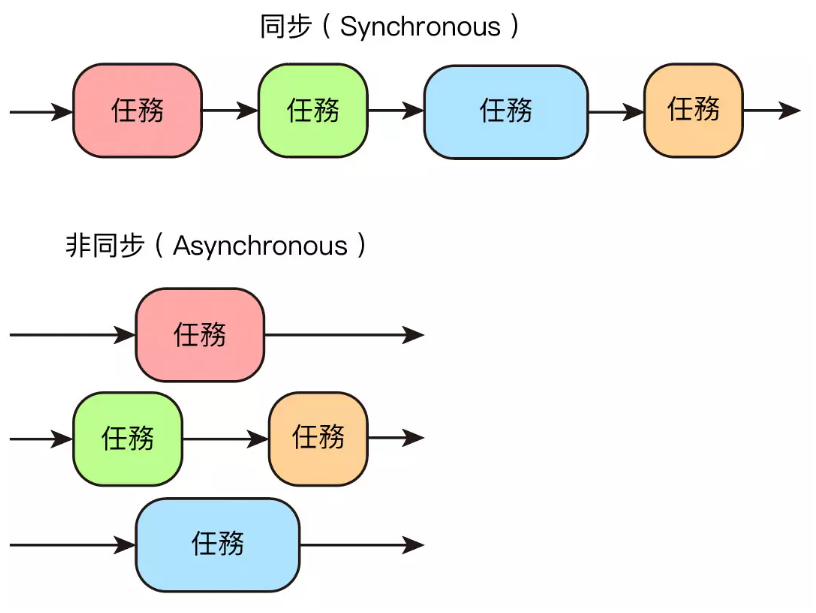

##### Thread 和 Process 
concurrent.futures 提供了 ThreadPoolExecutor 和 ProcessPoolExecutor 兩種可以平行處理任務的實作方法，ThreadPoolExecutor 是\
針對Thread ( 執行緒 )，ProcessPoolExecutor 是針對 Process ( 程序 )，下方是 Thread 和 Process 的簡單差異說明：

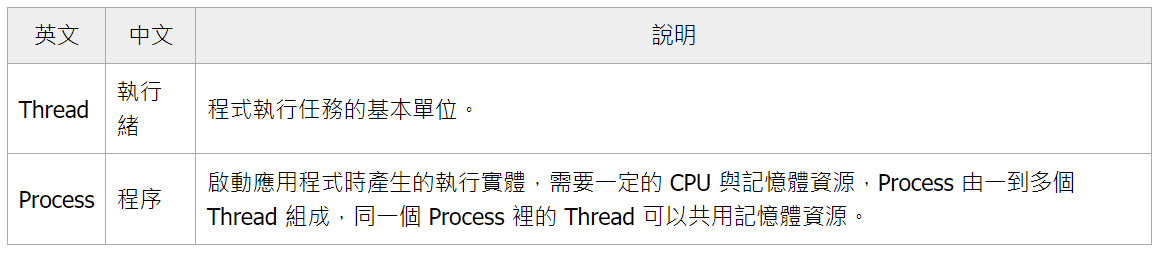

##### import concurrent.futures 
要使用 concurrent.futures 必須先 import concurrent.futures 模組，或使用 from 的方式，單獨 import 特定的類型。

更多資訊可以參考 Python 官方文件：[concurrent.futures 啟動平行任務](https://docs.python.org/zh-tw/3/library/concurrent.futures.html)

In [ ]:
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor

##### ThreadPoolExecutor 
ThreadPoolExecutor 會透過 Thread 的方式建立多個 Executors ( 執行器 ) ，執行並處理多個任務 ( tasks )，ThreadPoolExecutor 有四個參數，\
最常用的為 max_workers：

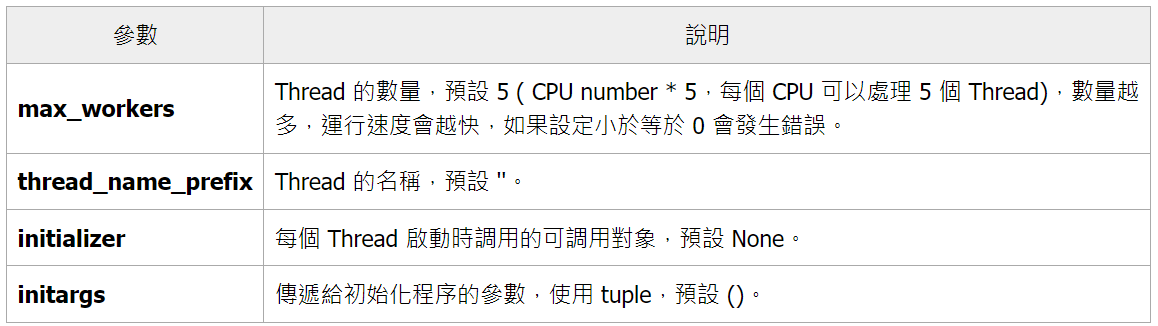

使用 ThreadPoolExecutor 後，就能使用 Executors 的相關方法：

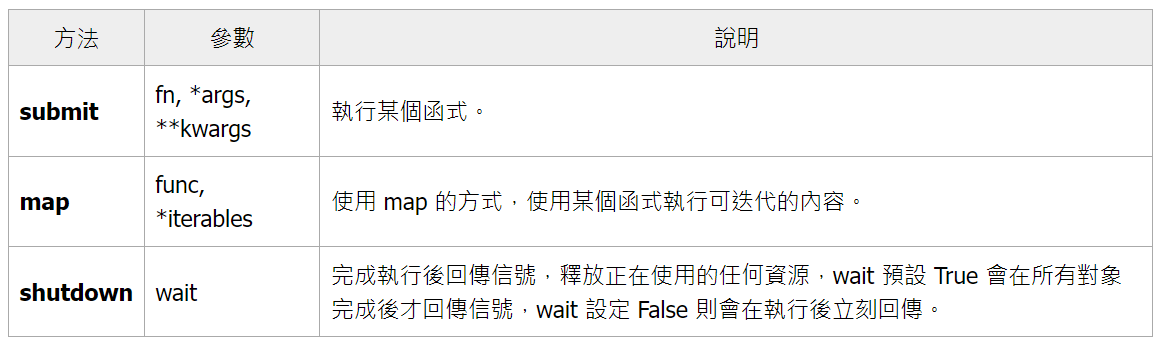

舉例來說，下方的程式碼執行後，會按照順序 ( 同步 ) 顯示出數字，前一個任務尚未處理完，就不會執行後續的工作。

In [ ]:
import time
def test(n):
    for i in range(n):
        print(i, end=' ')
        time.sleep(0.2)

test(2)
test(3)
test(4)

# 0 1 0 1 2 0 1 2 3

如果改成 ThreadPoolExecutor 的方式，就會發現三個函式就會一起進行 ( 如果執行的函式大於 5，可再設定 max_workers 的數值 )。

In [ ]:
import time
from concurrent.futures import ThreadPoolExecutor

def test(n):
    for i in range(n):
        print(i, end=' ')
        time.sleep(0.2)

executor = ThreadPoolExecutor()  # 設定一個執行 Thread 的啟動器

a = executor.submit(test, 2)     # 啟動第一個 test 函式
b = executor.submit(test, 3)     # 啟動第二個 test 函式
c = executor.submit(test, 4)     # 啟動第三個 test 函式
executor.shutdown()              # 關閉啟動器 ( 如果沒有使用，則啟動器會處在鎖住的狀態而無法繼續 )

# 0 0 0 1 1 1 2 2 3

上述的做法，可以改用 with...as 的方式 ( 有點類似 [open 的 with](https://steam.oxxostudio.tw/category/python/basic/builtin-open.html#a5) )。

In [ ]:
import time
from concurrent.futures import ThreadPoolExecutor

def test(n):
    for i in range(n):
        print(i, end=' ')
        time.sleep(0.2)

with ThreadPoolExecutor() as executor:    # 改用 with...as
    executor.submit(test, 2)
    executor.submit(test ,3)
    executor.submit(test, 4)

# 0 0 0 1 1 1 2 2 3

上述的範例，也可以改用 map 的做法：

In [ ]:
import time
from concurrent.futures import ThreadPoolExecutor

def test(n):
    for i in range(n):
        print(i, end=' ')
        time.sleep(0.2)

with ThreadPoolExecutor() as executor:
    executor.map(test, [2,3,4])

# 0 0 0 1 1 1 2 2 3

##### 輸入文字，停止函式執行 
透過平行任務處理的方法，就能輕鬆做到「輸入文字，停止正在執行的函式」，以下方的例子而言，run 是一個具有「無窮迴圈」的函式，\
如果不使用平行任務處理，在 run 後方的程式都無法運作 ( 會被無窮迴圈卡住 )，而 keyin 是一個具有「input」指令的函式，如果不使用\
平行任務處理，在 keyin 後方的程式也無法運作 ( 會被 input 卡住 )，因此如果使用 concurrent.futures，就能讓兩個函式同時運行，搭配\
全域變數的做法，就能在輸入特定指令時，停止另外函式的運作。

In [ ]:
import time
from concurrent.futures import ThreadPoolExecutor

a = True               # 定義 a 為 True

def run():
    global a           # 定義 a 是全域變數
    while a:           # 如果 a 為 True
        print(123)     # 不斷顯示 123
        time.sleep(1)  # 每隔一秒

def keyin():
    global a           # 定義 a 是全域變數
    if input() == 'a':
        a = False      # 如果輸入的是 a，就讓 a 為 False，停止 run 函式中的迴圈

executor = ThreadPoolExecutor()
e1 = executor.submit(run)
e2 = executor.submit(keyin)
executor.shutdown()

##### ProcessPoolExecutor 
ProcessPoolExecutor 會透過 Process 的方式建立多個 Executors ( 執行器 )，執行並處理多個程序，ProcessPoolExecutor 有四個參數，\
最常用的為 max_workers：

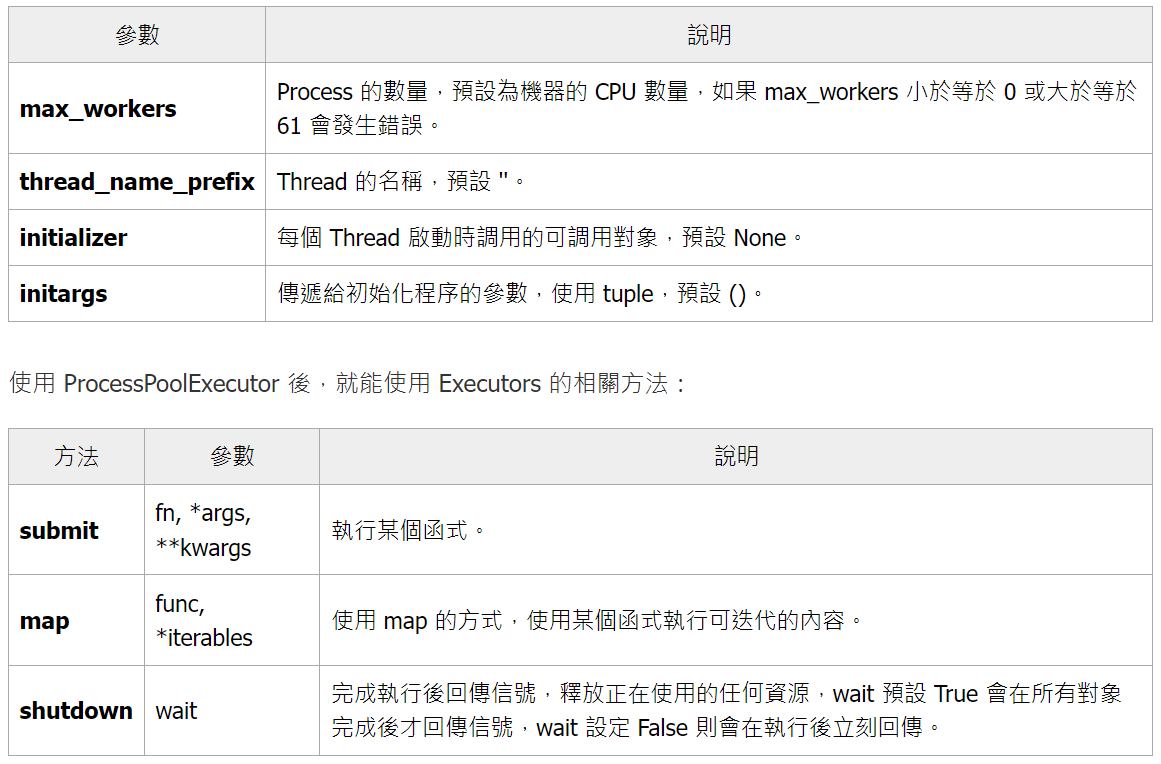

ProcessPoolExecutor 的用法基本上和 ThreadPoolExecutor 很像，但 ProcessPoolExecutor 主要會用做處理比較需要運算的程式，\
ThreadPoolExecutor 會使用於等待輸入和輸出 ( I/O ) 的程式，兩者執行後也會有些差別，ProcessPoolExecutor 執行後最後是顯示\
運算結果，而 ThreadPoolExecutor 則是顯示過程。

In [ ]:
import time
from concurrent.futures import ProcessPoolExecutor

def test(n):
    for i in range(n):
        print(i, end=' ')
        time.sleep(0.2)
    print()

with ProcessPoolExecutor() as executor:
    executor.map(test, [4,5,6])

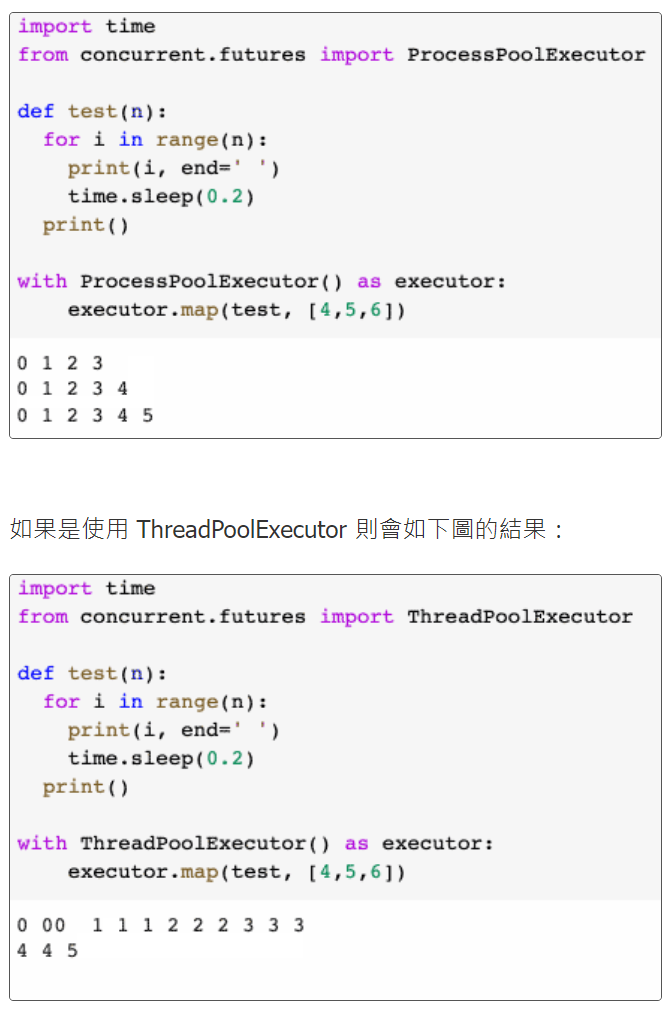

此外，Python 3.5 之後 map() 方法多了 chunksize 參數可以使用，該參數只對 ProcessPoolExecutor 有效，可以提升處理大量可迭代物件的\
執行效能，chunksize 預設 1，數值越大效能越好 ( 以電腦本身 CPU 的效能為主 )。

In [ ]:
import time
from concurrent.futures import ProcessPoolExecutor

def test(n):
    for i in range(n):
        print(i, end=' ')
        time.sleep(0.2)
    print()

with ProcessPoolExecutor() as executor:
    executor.map(test, [4,5,6], chunksize=5)  # 設定 chunksize

##### 小結 
Python 的 concurrent.futures 內建函式庫是一個相當方便的函式庫，不僅可以讓原本同步的執行變成非同步，\
大幅減少工作時間，用法上也比使用 multiprocessing、threading、asyncio 容易得多，是相當推薦的內建函式庫。